Machine Learning Part

In [1]:
!pip install q tensorflow==2.1
!pip install segmentation-models
!pip install --upgrade --no-cache-dir gdown

  Using cached q-2.7-py2.py3-none-any.whl.metadata (811 bytes)
ERROR: Could not find a version that satisfies the requirement tensorflow==2.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.1


In [28]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import cv2
import numpy as np
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [29]:
os.environ['SM_FRAMEWORK'] = 'tf.keras'

In [7]:
!gdown 1lal7GYMwA2pNoZpLJXvrGeaM6Up4B7Tk

Downloading...
From (original): https://drive.google.com/uc?id=1lal7GYMwA2pNoZpLJXvrGeaM6Up4B7Tk
From (redirected): https://drive.google.com/uc?id=1lal7GYMwA2pNoZpLJXvrGeaM6Up4B7Tk&confirm=t&uuid=5004c9bc-f7fc-488d-b03e-a6cb614dfe84
To: /notebooks/headsegmentation_dataset_ccncsa.zip
100%|██████████████████████████████████████| 1.76G/1.76G [00:19<00:00, 88.8MB/s]


# Dataset Preparation

In [17]:
local_zip = './headsegmentation_dataset_ccncsa.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [16]:
DATASET_PATH = '/tmp/'
DATASET_INDEX_NAME = 'training.xml'

## Preprocess and Load Dataset

In [36]:
import os
import xml.etree.ElementTree as ET
from tensorflow.keras.utils import Sequence
from PIL import Image

class FaceSegmentationDataset(tf.keras.utils.Sequence):
    def __init__(self, img_paths, label_paths, batch_size, target_size):
        self.img_paths = img_paths
        self.label_paths = label_paths
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return len(self.img_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_img_paths = self.img_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_label_paths = self.label_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_imgs = []
        batch_labels = []
        for img_path, label_path in zip(batch_img_paths, batch_label_paths):
            img = Image.open(img_path).convert('RGB')
            img = img.resize(self.target_size)
            img = np.array(img) / 255.0
            batch_imgs.append(img)

            label = Image.open(label_path).convert('RGB')
            label = label.resize(self.target_size, resample=Image.NEAREST)
            label = self.map_labels(label)
            batch_labels.append(label)

        return np.array(batch_imgs), np.array(batch_labels)

    def map_labels(self, label):
        label_array = np.array(label)
        label_map = np.zeros((label_array.shape[0], label_array.shape[1], n_classes))
        for i, rgb in enumerate(rgb_values):
            mask = np.all(label_array == rgb, axis=-1)
            label_map[mask, i] = 1
        return label_map


def get_paths(dataset_path, file_name):
    tree = ET.parse(os.path.join(dataset_path, file_name))
    root = tree.getroot()
    img_paths = []
    label_paths = []
    for child in root:
        if child.tag == "srcimg":
            img_path = os.path.join(dataset_path, child.attrib['name']).replace('\\', '/')
            img_paths.append(img_path)
        elif child.tag == "labelimg":
            label_path = os.path.join(dataset_path, child.attrib['name']).replace('\\', '/')
            label_paths.append(label_path)

    assert (len(img_paths) == len(label_paths))
    return img_paths, label_paths


In [25]:
from typing import OrderedDict

segmentation_labels = OrderedDict({
    'background': [0, 0, 0],
    'lips': [255, 0, 0],
    'eyes': [0, 255, 0],
    'nose': [0, 0, 255],
    'skin': [128, 128, 128],
    'hair': [255, 255, 0],
    'eyebrows': [255, 0, 255],
    'ears': [0, 255, 255],
    'teeth': [255, 255, 255],
    'beard': [255, 192, 192],
    'sunglasses': [0, 128, 128],
})

labels = list(segmentation_labels.keys())
rgb_values = list(segmentation_labels.values())


In [26]:
from sklearn.model_selection import train_test_split


n_classes = len(segmentation_labels)
img_paths, label_paths = get_paths(DATASET_PATH, DATASET_INDEX_NAME)


# Split the dataset into train, validation, and test sets
train_img_paths, temp_img_paths, train_label_paths, temp_label_paths = train_test_split(
    img_paths, label_paths, test_size=0.2, random_state=42
)
val_img_paths, test_img_paths, val_label_paths, test_label_paths = train_test_split(
    temp_img_paths, temp_label_paths, test_size=0.5, random_state=42
)



## Uses Transfer Learning on Pre-trained U-Net Model

In [31]:
model = sm.Unet(
    backbone_name='resnet34',
    input_shape=(256, 256, 3),
    classes=n_classes,
    activation='softmax',
    encoder_weights='imagenet'
)

2024-06-07 07:44:59.090625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 07:44:59.134698: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 07:44:59.135016: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [37]:
batch_size = 8
target_size = (256, 256)

train_dataset = FaceSegmentationDataset(train_img_paths, train_label_paths, batch_size, target_size)
val_dataset = FaceSegmentationDataset(val_img_paths, val_label_paths, batch_size, target_size)
test_dataset = FaceSegmentationDataset(test_img_paths, test_label_paths, batch_size, target_size)

In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Epoch 1/10


2024-06-07 07:47:11.247688: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-07 07:47:14.319349: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4f3b633100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-07 07:47:14.319412: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-06-07 07:47:14.325813: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717746434.448148    2891 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1655/1655 [==============================] - 541s 309ms/step - loss: 0.3462 - accuracy: 0.8871 - val_loss: 0.2586 - val_accuracy: 0.9160
Epoch 2/10
1655/1655 [==============================] - 523s 316ms/step - loss: 0.1844 - accuracy: 0.9353 - val_loss: 0.1692 - val_accuracy: 0.9418
Epoch 3/10
1655/1655 [==============================] - 529s 319ms/step - loss: 0.1605 - accuracy: 0.9431 - val_loss: 0.1755 - val_accuracy: 0.9411
Epoch 4/10
1655/1655 [==============================] - 512s 309ms/step - loss: 0.1260 - accuracy: 0.9537 - val_loss: 0.1290 - val_accuracy: 0.9529
Epoch 5/10
1655/1655 [==============================] - 553s 334ms/step - loss: 0.1198 - accuracy: 0.9559 - val_loss: 0.1078 - val_accuracy: 0.9604
Epoch 6/10
1655/1655 [==============================] - 508s 307ms/step - loss: 0.1057 - accuracy: 0.9604 - val_loss: 0.1176 - val_accuracy: 0.9580
Epoch 7/10
1655/1655 [==============================] - 514s 311ms/step - loss: 0.0953 - accuracy: 0.9640 - val_loss: 0.117

## Saves the Model

In [39]:
model.save('UNet-ResNet34.keras')

In [42]:
U_Net = tf.keras.models.load_model('UNet-ResNet34.keras')

# Show the model architecture
U_Net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 256, 256, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

## Check the Prediction

1/1 [==============================] - 2s 2s/step


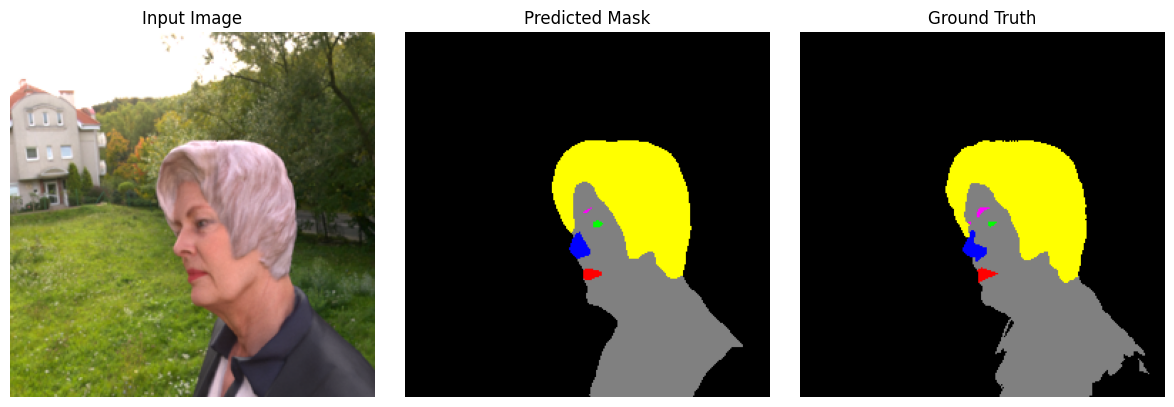

1/1 [==============================] - 0s 30ms/step


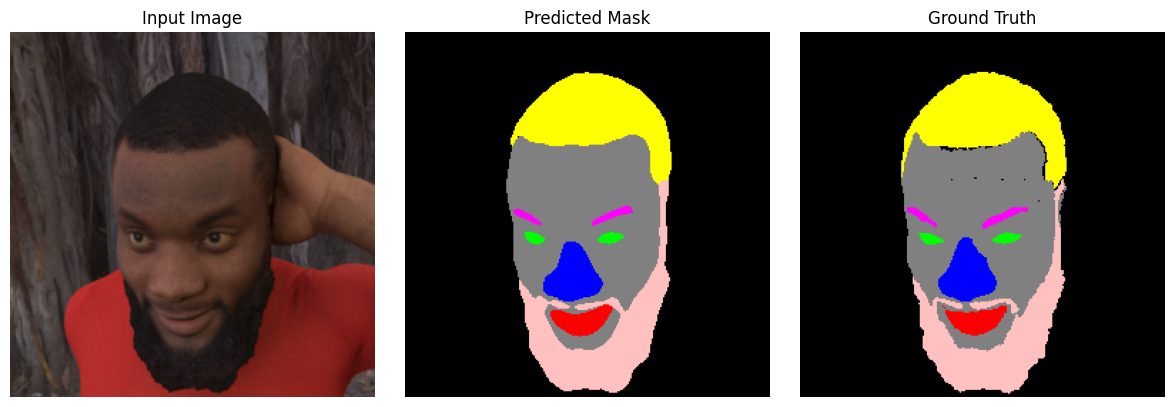

1/1 [==============================] - 0s 26ms/step


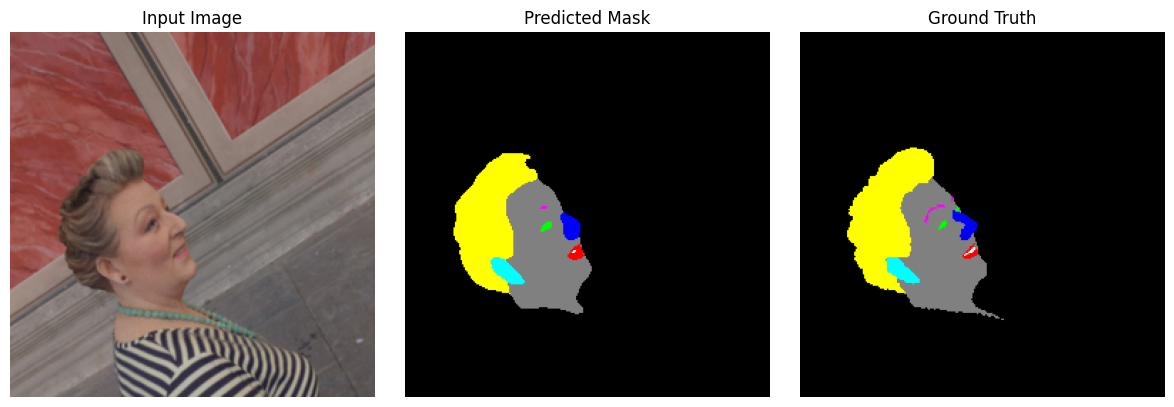

1/1 [==============================] - 0s 28ms/step


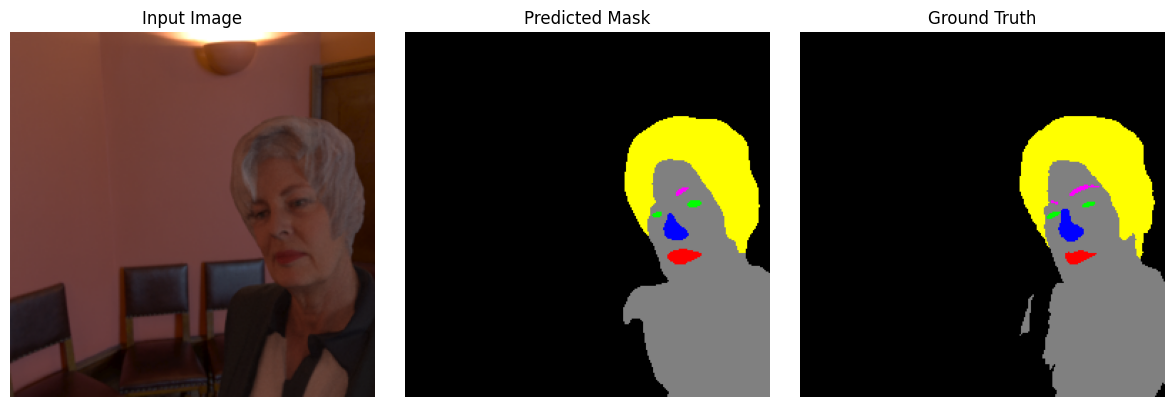

1/1 [==============================] - 0s 27ms/step


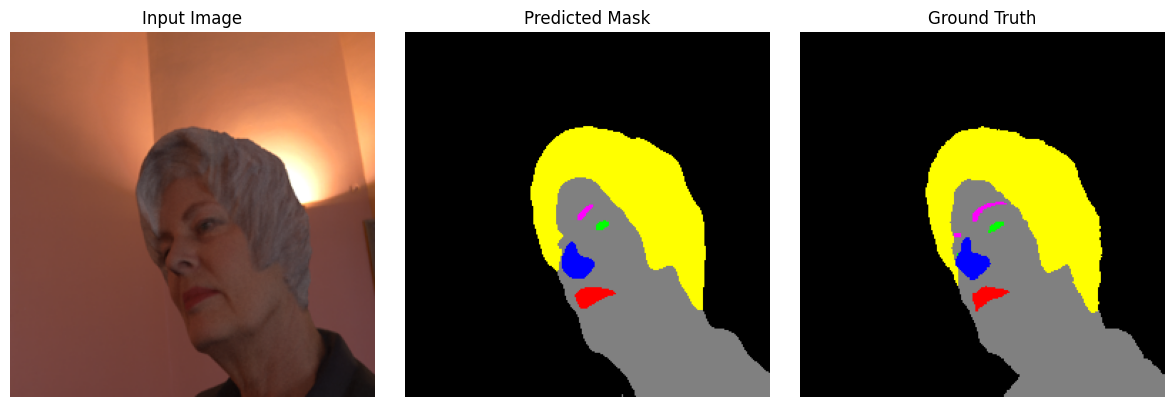

In [43]:
# Visualize predictions and ground truth labels
num_samples_to_visualize = 5
test_img_paths = test_img_paths[:num_samples_to_visualize]
test_label_paths = test_label_paths[:num_samples_to_visualize]

for img_path, label_path in zip(test_img_paths, test_label_paths):
    # Load and preprocess the image
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    pred_mask = model.predict(img_array)[0]
    pred_mask = np.argmax(pred_mask, axis=-1)

    # Load and preprocess the ground truth label
    label = Image.open(label_path).convert('RGB')
    label = label.resize(target_size, resample=Image.NEAREST)
    label_array = np.array(label)

    # Map the predicted mask and ground truth label to RGB colors
    pred_rgb = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    gt_rgb = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    for i, rgb in enumerate(rgb_values):
        pred_rgb[pred_mask == i] = rgb
        gt_rgb[np.all(label_array == rgb, axis=-1)] = rgb

    # Plot the image, predicted mask, and ground truth label
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img)
    axs[0].set_title('Input Image')
    axs[0].axis('off')
    axs[1].imshow(pred_rgb)
    axs[1].set_title('Predicted Mask')
    axs[1].axis('off')
    axs[2].imshow(gt_rgb)
    axs[2].set_title('Ground Truth')
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()